## 0. Import Libraries and Define Some Useful Functions

In [1]:
# import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC

In [2]:
# global vars
RANDOM_SEED = 42
VAL_FILE_PATH = './dataset/validation.jsonl'
TEST_FILE_PATH = './dataset/test_features.jsonl'

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# load val data as df
def load_val_data():
    try:
        df_val = pd.read_json(VAL_FILE_PATH, lines=True)
        print(f"Load {len(df_val)} validation paragraphs.")
        return df_val
    except FileNotFoundError:
        print(f"Error: No such file: '{VAL_FILE_PATH}'")
        exit()


# load test data as df
def load_test_data():
    try:
        df_test = pd.read_json(TEST_FILE_PATH, lines=True)
        print(f"Load {len(df_test)} test paragraphs")
        return df_test
    except FileNotFoundError:
        print(f"Error: No such file: {TEST_FILE_PATH}")
        exit()
        
        
# preprocess full training data by pooling method
def process_train_full(ai_data, human_data, method):
    X_ai = np.array([method(s) for s in ai_data])
    X_human = np.array([method(s) for s in human_data])
    return np.concatenate([X_ai, X_human], axis=0)


# concat 2D data (training data, validation data)
def concat_train_and_validation(X_train, X_val, y_train, y_val):
    X_big_train = np.concatenate([X_train, X_val], axis=0)
    y_big_train = np.concatenate([y_train, y_val], axis=0)
    return shuffle(X_big_train, y_big_train, random_state=42)

In [4]:
# save training history
def save_history_as_csv(history, csv_filename):
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history_df.index + 1
    history_df.to_csv(csv_filename, index=False) 
    print(f"'{csv_filename}' saved successfully.")


# plot confusion matrix
def display_confusion_matrix(y_true, y_pred_labels):
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Human', 'AI'], 
                yticklabels=['Human', 'AI'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    

# plot roc curve
def display_roc(y_true, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # random prediction
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# plot learning curves
def plot_learning_curves(history):
    history_dict = history.history
    train_loss = history_dict.get('loss')
    val_loss = history_dict.get('val_loss')
    train_auc = history_dict.get('auc') 
    val_auc = history_dict.get('val_auc')

    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(8, 6))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss', alpha=0.5)
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss', alpha=0.5)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim(1, len(train_loss)) 
    plt.grid(False)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_auc, 'b-', label='Training AUC', alpha=0.5)
    plt.plot(epochs, val_auc, 'r-', label='Validation AUC', alpha=0.5)
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.xlim(1, len(train_loss)) 
    plt.grid(False)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# get prepared validation data
def get_prepared_val_data(processing_method=None):
    """
    Args:
        model: (Keras, XGBoost, or Scikit-learn).
        name (str): ('mlp', 'cnn', 'lstm', 'lr', 'xgboost').
        df_val (pd.DataFrame): Validation DataFrame.
        processing_method (function, optional): pooling for mlp or lr. 
    """
    df_val = load_val_data()
    y_val_paragraphs_true = df_val['label'].values
    
    all_sentences_to_predict = []
    y_val_sentences_true = []
    paragraph_lengths = []

    for index, row in df_val.iterrows():
        paragraph_label = row['label']
        paragraph_sentences_raw = row['features']
        
        if not paragraph_sentences_raw:
            paragraph_lengths.append(0)
            continue
            
        paragraph_lengths.append(len(paragraph_sentences_raw))
        
        for sentence_features in paragraph_sentences_raw:
            # if preprocessing
            if processing_method is not None:
                sentence = processing_method(sentence_features)
            else:
                sentence = np.array(sentence_features)
                
            all_sentences_to_predict.append(sentence)
            y_val_sentences_true.append(paragraph_label)

    X_val_sentences = np.array(all_sentences_to_predict).astype('float32') 
    y_val_sentences_true = np.array(y_val_sentences_true).astype('int32')
    print(f"Data prepared for prediction. Shape: {X_val_sentences.shape}")
    
    return X_val_sentences, y_val_sentences_true, y_val_paragraphs_true, paragraph_lengths, df_val.index

In [6]:
# predict val sentences function
def predict_val_sentences(X_val_sentences, paragraph_lengths, df_val_index, model, name):

    if name in ["lr", "xgboost"]:
        if X_val_sentences.ndim != 2:
            raise ValueError(f"{name} model expects 2D data, but got {X_val_sentences.ndim}D.")
        y_val_sentences_pred_prob = model.predict_proba(X_val_sentences)[:, 1]
        
    elif name in ["mlp", "cnn", "lstm"]:
        if name == "mlp" and X_val_sentences.ndim != 2:
            raise ValueError(f"MLP model expects 2D data, but got {X_val_sentences.ndim}D.")
        if name in ["cnn", "lstm"] and X_val_sentences.ndim != 3:
             raise ValueError(f"{name} model expects 3D data, but got {X_val_sentences.ndim}D.")
        y_val_sentences_pred_prob = model.predict(X_val_sentences, verbose=0).flatten()
        
    else:
        raise ValueError(f"Unknown model name: {name}")

    # restructure the results
    y_val_sentences_pred_label = (y_val_sentences_pred_prob > 0.5).astype(int)
    
    paragraph_sentence_probs = {}
    current_pos = 0
    for i, length in enumerate(paragraph_lengths):
        paragraph_index = df_val_index[i]
        if length == 0:
            paragraph_sentence_probs[paragraph_index] = []
        else:
            probs_for_para = y_val_sentences_pred_prob[current_pos : current_pos + length]
            paragraph_sentence_probs[paragraph_index] = probs_for_para
            current_pos += length

    print("Validation prediction complete.")
    
    return y_val_sentences_pred_prob, y_val_sentences_pred_label, paragraph_sentence_probs

In [7]:
# aggregation the sentence probs to get paragraph prediction
def aggregate_sentence_probs(paragraph_sentence_probs, df_val_index, method):
    y_val_paragraph_probs_pred = []
    y_val_paragraph_labels_pred = []
    for index in df_val_index:
        probs = paragraph_sentence_probs[index]
        agg_prob = method(probs)
        y_val_paragraph_probs_pred.append(agg_prob)
        y_val_paragraph_labels_pred.append(int(agg_prob > 0.5))
    
    return y_val_paragraph_probs_pred, y_val_paragraph_labels_pred

In [8]:
# evaluate different aggregation methods for paragraph prediction
def evaluate_aggregation_methods(aggregations, paragraph_sentence_probs, y_val_paragraphs_true, df_val_index):
    print("\n--- Paragraph-level Results ---")
    for name, func in aggregations.items():
        y_val_paragraph_probs_pred, y_val_paragraph_labels_pred = aggregate_sentence_probs(paragraph_sentence_probs, df_val_index, func)
        auc_score = roc_auc_score(y_val_paragraphs_true, y_val_paragraph_probs_pred)
        acc = accuracy_score(y_val_paragraphs_true, y_val_paragraph_labels_pred)
        print(f"Method: {name:<20} | AUC = {auc_score:.4f}, Accuracy = {acc:.4f}")

In [9]:
# generate the final test data submission of a model
def generate_submission(model, model_type, submission_filename,
                        pooling_method=None, aggregation_method=np.mean):
    """

    Args:
        model: (Keras, XGBoost, or Scikit-learn).
        model_type (str): ('mlp', 'cnn', 'lstm', 'lr', 'xgboost').
        df_test (pd.DataFrame): test DataFrame.
        submission_filename (str):  e.g., 'submission_cnn.csv'.
        pooling_method (function, optional):default: None.
        aggregation_method (function, optional): default: np.mean.
    """
    print(f"--- Starting prediction for model: {model_type.upper()} ---")
    print(f"Pooling method: {'None' if pooling_method is None else pooling_method.__name__}")
    print(f"Aggregation method: {aggregation_method.__name__}")
    
    df_test = load_test_data()
    submission_data = []

    for index, row in df_test.iterrows():
        paragraph_id = row['id']
        paragraph_features_raw = row['features']
        
        if not paragraph_features_raw:
            paragraph_prob = 0.5
        else:
            if model_type in ['cnn', 'lstm']:
                if pooling_method is not None:
                    print("Warning: CNN/LSTM models should not use a pooling_method. Ignoring it.")
                X_batch = np.array([np.array(s) for s in paragraph_features_raw]).astype('float32')
            
            elif model_type in ['mlp', 'xgboost', 'lr']:
                if pooling_method is None:
                    raise ValueError(f"Model type '{model_type}' requires a pooling_method.")
                X_batch = np.array([pooling_method(s) for s in paragraph_features_raw]).astype('float32')
            
            else:
                raise ValueError(f"Unknown model_type: {model_type}")

            if model_type in ['xgboost', 'lr']:
                sentence_probs = model.predict_proba(X_batch)[:, 1]
            else: # Keras models (mlp, cnn, lstm)
                sentence_probs = model.predict(X_batch, verbose=0).flatten()
                
            # aggregation
            paragraph_prob = aggregation_method(sentence_probs)
            
        submission_data.append({'id': paragraph_id, 'y_prob': paragraph_prob})

    # save
    df_submission = pd.DataFrame(submission_data)
    df_submission.to_csv(submission_filename, index=False)
    print(f"\nSubmission file '{submission_filename}' successfully created.")

In [10]:
# get the predictions of the ensemble model
def get_ensemble_predictions(df, loaded_models, best_agg_methods, pooling_method, ensemble_method):
    """
    
    Args:
        df (pd.DataFrame): df_test
        models (dict): dictionary containing loaded models
        best_agg_methods (dict): best aggregation methods for each model
        pooling_method (func): 2D data pooling
        ensemble_method (func): np.mean or np.median
        
    Returns:
        tuple: (a list containing all paragraph IDs, a list containing all final ensemble probabilities)
    """
    model_names = list(loaded_models.keys())
    print(f"--- Getting ensemble predictions for models: {model_names} ---")
    
    paragraph_ids = []
    final_paragraph_probs = []

    for index, row in df.iterrows():
        paragraph_id = row['id']
        paragraph_features_raw = row['features']
        
        paragraph_ids.append(paragraph_id)
        
        paragraph_probs_from_models = []
        
        if not paragraph_features_raw:
            final_prob = 0.5
        else:
            X_batch_2d = np.array([pooling_method(s) for s in paragraph_features_raw]).astype('float32') if pooling_method else None
            X_batch_3d = np.array([np.array(s) for s in paragraph_features_raw]).astype('float32')

            for model_name, model in loaded_models.items():
                if model_name in ['cnn', 'lstm']:
                    sentence_probs = model.predict(X_batch_3d, verbose=0).flatten()
                elif model_name == 'mlp':
                    sentence_probs = model.predict(X_batch_2d, verbose=0).flatten()
                elif model_name in ['lr', 'xgboost']:
                    sentence_probs = model.predict_proba(X_batch_2d)[:, 1]
                else:
                    raise ValueError(f"Unknown model name: {model_name}")

                agg_func = best_agg_methods[model_name]
                paragraph_prob = agg_func(sentence_probs)
                paragraph_probs_from_models.append(paragraph_prob)

            final_prob = ensemble_method(paragraph_probs_from_models)
            
        final_paragraph_probs.append(final_prob)
        
        if (index + 1) % 50 == 0:
            print(f"Processed {index + 1}/{len(df)} samples...")
            
    print("Prediction generation complete.")
    return paragraph_ids, final_paragraph_probs

In [11]:
# create a submission file
def create_submission_file(paragraph_ids, paragraph_probs, submission_filename):
    """
    Args:
        paragraph_ids (list)
        paragraph_probs (list)
        submission_filename (str)
    """
    print(f"\n--- Creating submission file: {submission_filename} ---")
    
    submission_df = pd.DataFrame({
        'id': paragraph_ids,
        'y_prob': paragraph_probs
    })
    
    submission_df.to_csv(submission_filename, index=False)
    print(f"Submission file '{submission_filename}' successfully created.")

## 1. Data Exploration


### 1.1 Load Data

In [12]:
# training data
data_dir = './dataset/'
try:
    ai_mmap = np.load('dataset/train_ai.npy', mmap_mode='r')
    human_mmap = np.load('dataset/train_human.npy', mmap_mode='r')
except FileNotFoundError:
    print("Error: 'train_ai.npy' of'train_human.npy' not found")
    exit()

y_ai = np.ones(ai_mmap.shape[0])
y_human = np.zeros(human_mmap.shape[0])
y_train_full = np.concatenate([y_ai, y_human], axis=0)

### 1.2 Dataset Information

In [13]:
# training data info
num_ai_samples = ai_mmap.shape[0]
num_human_samples = human_mmap.shape[0]
total_samples = num_ai_samples + num_human_samples

print("--- Training Dataset Statistics ---")
print(f"Number of AI-generated sentences: {num_ai_samples}")
print(f"Number of Human-written sentences: {num_human_samples}")
print(f"Total training sentences: {total_samples}")
print(f"Class Balance: AI accounts for {num_ai_samples / total_samples:.2%} of the data.")

--- Training Dataset Statistics ---
Number of AI-generated sentences: 8161
Number of Human-written sentences: 8161
Total training sentences: 16322
Class Balance: AI accounts for 50.00% of the data.


In [14]:
print(f"Embedding input shape: {ai_mmap.shape}")

Embedding input shape: (8161, 100, 768)


In [15]:
# check all-zero tokens
mask_ai = np.all(ai_mmap == 0, axis=2)        # shape: (8161, 100)
mask_human = np.all(human_mmap == 0, axis=2)  # shape: (8161, 100)
zero_counts_ai = np.sum(mask_ai, axis=1)       # shape: (8161,)
zero_counts_human = np.sum(mask_human, axis=1) # shape: (8161,)

# Calculate actual sentence lengths
sentence_lengths_ai = 100 - zero_counts_ai
sentence_lengths_human = 100 - zero_counts_human

print("\n--- Sentence Length Analysis ---")
print(f"The mean sentence length in AI data is {np.mean(sentence_lengths_ai):.2f} tokens.")
print(f"The mean sentence length in Human data is {np.mean(sentence_lengths_human):.2f} tokens.")


--- Sentence Length Analysis ---
The mean sentence length in AI data is 27.02 tokens.
The mean sentence length in Human data is 25.45 tokens.


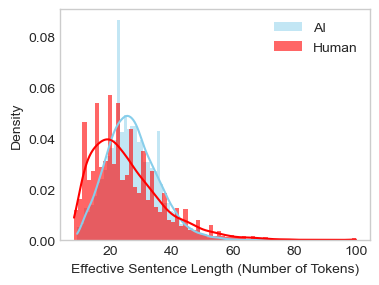

In [16]:
# Visualize the sentence lengths distributions
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(4, 3))
sns.histplot(sentence_lengths_ai, color="skyblue", label='AI', kde=True, stat="density", linewidth=0)
sns.histplot(sentence_lengths_human, color="red", label='Human', kde=True, stat="density", linewidth=0, alpha=0.6)
plt.xlabel('Effective Sentence Length (Number of Tokens)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.legend()
plt.grid(False)
plt.show()

In [17]:
df_val = load_val_data()
df_test = load_test_data()

Load 20 validation paragraphs.
Load 180 test paragraphs


In [20]:
# validation info
print("--- Validation Set Statistics ---")

# paragraphs
paragraph_counts = df_val['label'].value_counts()

num_ai_paragraphs = paragraph_counts.get(1, 0)
num_human_paragraphs = paragraph_counts.get(0, 0)
total_paragraphs = len(df_val)

print(f"Total number of paragraphs: {total_paragraphs}")
print(f"Number of AI paragraphs (label=1): {num_ai_paragraphs}")
print(f"Number of Human paragraphs (label=0): {num_human_paragraphs}")

# sentences
ai_sentence_count = 0
human_sentence_count = 0

for index, row in df_val.iterrows():
    label = row['label']
    paragraph_sentences = row['features']
    if paragraph_sentences and isinstance(paragraph_sentences, list):
        num_sentences_in_para = len(paragraph_sentences)
        if label == 1: # AI
            ai_sentence_count += num_sentences_in_para
        else: # Human
            human_sentence_count += num_sentences_in_para

total_sentences = ai_sentence_count + human_sentence_count

print(f"Total number of sentences: {total_sentences}")
print(f"Number of sentences in AI paragraphs: {ai_sentence_count}")
print(f"Number of sentences in Human paragraphs: {human_sentence_count}")

--- Validation Set Statistics ---
Total number of paragraphs: 20
Number of AI paragraphs (label=1): 10
Number of Human paragraphs (label=0): 10
Total number of sentences: 220
Number of sentences in AI paragraphs: 96
Number of sentences in Human paragraphs: 124


In [ ]:
def get_sentences_per_paragraph_stats(df, df_name="Dataset"):
    """ count the number of sentences in a paragraph"""
    sentences_per_paragraph = []
    
    for index, row in df.iterrows():
        paragraph_features_raw = row['features']
        num_sentences = len(paragraph_features_raw) if paragraph_features_raw else 0
        sentences_per_paragraph.append(num_sentences)

    if not sentences_per_paragraph:
        print("No paragraphs found in the dataset.")
        return []

    min_sents = np.min(sentences_per_paragraph)
    max_sents = np.max(sentences_per_paragraph)
    mean_sents = np.mean(sentences_per_paragraph)
    median_sents = np.median(sentences_per_paragraph)

    print(f"\n--- {df_name} Statistics ---")
    print(f"Total paragraphs: {len(df)}")
    print(f"Sentences per Paragraph Range: [{min_sents}, {max_sents}]")
    print(f"Mean Sentences per Paragraph: {mean_sents:.2f}")
    
    return sentences_per_paragraph

In [78]:
# sentence statistics in the paragraphs
val_sents_per_para = get_sentences_per_paragraph_stats(df_val, "Validation Set (df_val)")
test_sents_per_para = get_sentences_per_paragraph_stats(df_test, "Test Set (df_test)")


--- Validation Set (df_val) Statistics ---
Total paragraphs: 20
Sentences per Paragraph Range: [4, 20]
Mean Sentences per Paragraph: 11.00

--- Test Set (df_test) Statistics ---
Total paragraphs: 180
Sentences per Paragraph Range: [4, 16]
Mean Sentences per Paragraph: 9.37


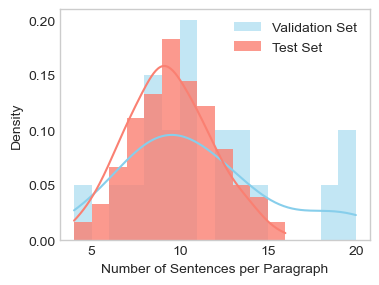

In [76]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(4, 3))
sns.histplot(val_sents_per_para, color="skyblue", label='Validation Set', kde=True, stat="density", binwidth=1, edgecolor=None)
sns.histplot(test_sents_per_para, color="salmon", label='Test Set', kde=True, stat="density", binwidth=1, alpha=0.8, edgecolor=None)
plt.xlabel('Number of Sentences per Paragraph', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.legend()
plt.grid(False)
plt.show()

### 1.3 2D Data Preprocessing

#### 1.3.1 Feature Extraction - Pooling Strategy Evaluation

For models which can't process sequence inputs directly. Use a simple sklearn logistic regression to evaluate.

In [17]:
# feature engineering

def process_with_mean(sentence_tensor):
    """mean pooling (remove zero paddings)"""
    sentence_tensor = np.array(sentence_tensor)
    if sentence_tensor.ndim != 2:
        return np.zeros(768) 
    valid_tokens = sentence_tensor[np.any(sentence_tensor != 0, axis=1)]
    if len(valid_tokens) == 0:
        return np.zeros(sentence_tensor.shape[1])
    return valid_tokens.mean(axis=0)


def process_with_max(sentence_tensor):
    """max pooling (remove zero paddings)"""
    sentence_tensor = np.array(sentence_tensor)
    if sentence_tensor.ndim != 2:
        return np.zeros(768) 
    valid_tokens = sentence_tensor[np.any(sentence_tensor != 0, axis=1)]
    if len(valid_tokens) == 0:
        return np.zeros(sentence_tensor.shape[1])
    return valid_tokens.max(axis=0)


def process_with_topK_mean(sentence_tensor, k_ratio=0.3):
    """top-k mean pooling (remove zero paddings)"""
    sentence_tensor = np.array(sentence_tensor)
    if sentence_tensor.ndim != 2:
        return np.zeros(768) 
    valid_tokens = sentence_tensor[np.any(sentence_tensor != 0, axis=1)]
    if len(valid_tokens) == 0:
        return np.zeros(sentence_tensor.shape[1])
    k = max(1, int(len(valid_tokens) * k_ratio))
    idx = np.argsort(-np.linalg.norm(valid_tokens, axis=1))[:k]
    return valid_tokens[idx].mean(axis=0)


def process_with_mean_keep_zero(sentence_tensor):
    """mean pooling (keep zero paddings)"""
    sentence_tensor = np.array(sentence_tensor)
    if sentence_tensor.ndim != 2:
        return np.zeros(768) 
    return sentence_tensor.mean(axis=0)


def process_with_max_keep_zero(sentence_tensor):
    """max pooling (keep zero paddings)"""
    sentence_tensor = np.array(sentence_tensor)
    if sentence_tensor.ndim != 2:
        return np.zeros(768) 
    return sentence_tensor.max(axis=0)


def process_with_topK_mean_keep_zero(sentence_tensor, k_ratio=0.3):
    """top-k mean pooling (keep zero paddings)"""
    sentence_tensor = np.array(sentence_tensor)
    if sentence_tensor.ndim != 2:
        return np.zeros(768) 
    k = max(1, int(len(sentence_tensor) * k_ratio))
    idx = np.argsort(-np.linalg.norm(sentence_tensor, axis=1))[:k]
    return sentence_tensor[idx].mean(axis=0)


def process_with_cls(sentence_tensor):
    """[CLS]"""
    return sentence_tensor[0]

In [18]:
# different strategies
strategies = {
    "Mean Pooling (Remove Zero Paddings)": process_with_mean,
    "Max Pooling (Remove Zero Paddings)": process_with_max,
    "Top-K Mean Pooling (Remove Zero Paddings)": process_with_topK_mean,
    "Mean Pooling (Keep Zero Paddings)": process_with_mean_keep_zero,
    "Max Pooling (Keep Zero Paddings)": process_with_max_keep_zero,
    "Top-K Mean Pooling (Keep Zero Paddings)": process_with_topK_mean_keep_zero,
    "[CLS] Token": process_with_cls
    }

In [19]:
# select the best pooling method
from sklearn.linear_model import LogisticRegression

for name, func in strategies.items():
    print(f"\nStrategy: {name}")
    X_train_full = process_train_full(ai_mmap, human_mmap, func)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                      test_size=0.2, random_state=42, 
                                                      stratify=y_train_full)
    
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train, y_train)
    y_val_pred_probs = lr_model.predict_proba(X_val)[:, -1]
    y_val_pred_labels = lr_model.predict(X_val)
    
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_probs, pos_label=1)
    auroc = auc(fpr, tpr)
    acc = accuracy_score(y_val, y_val_pred_labels)
    print(f"AUC = {auroc:.4f}, Accuracy = {acc:.4f}")


Strategy: Mean Pooling (Remove Zero Paddings)
AUC = 0.9622, Accuracy = 0.8959

Strategy: Max Pooling (Remove Zero Paddings)
AUC = 0.9548, Accuracy = 0.8861

Strategy: Top-K Mean Pooling (Remove Zero Paddings)
AUC = 0.9547, Accuracy = 0.8861

Strategy: Mean Pooling (Keep Zero Paddings)
AUC = 0.9409, Accuracy = 0.8671

Strategy: Max Pooling (Keep Zero Paddings)
AUC = 0.9515, Accuracy = 0.8784

Strategy: Top-K Mean Pooling (Keep Zero Paddings)
AUC = 0.9587, Accuracy = 0.8888

Strategy: [CLS] Token
AUC = 0.9473, Accuracy = 0.8741


**Conclusion:**

Based on the AUC results, the best data pooling method for Logistic Regression is **Mean Pooling (Remove Zero Paddings).**

In [20]:
# preprocess training data with mean pooling
X_train_full = process_train_full(ai_mmap, human_mmap, process_with_mean)

#### 1.3.2 Scaler Evaluation
Use a simple sklearn logistic regression to evaluate different scalers.

In [21]:
# try different scalers for preprocessing data
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                  test_size=0.2, random_state=42, 
                                                  stratify=y_train_full)

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "Without Scaler": None
}

for name, scaler in scalers.items():
    print(f"\nScaler: {name}")
    if scaler is None: # without a scaler
        lr_pl = Pipeline([
            ("lr", LogisticRegression(max_iter=1000, random_state=42))
            ])
    lr_pl = Pipeline([
        ("scaler", scaler),
        ("lr", LogisticRegression(max_iter=1000, random_state=42))
    ])

    lr_pl.fit(X_train, y_train)
    y_val_pred_probs = lr_pl.predict_proba(X_val)[:, -1]
    y_val_pred_labels = lr_pl.predict(X_val)
    
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_probs, pos_label=1)
    auroc = auc(fpr, tpr)
    acc = accuracy_score(y_val, y_val_pred_labels)
    print(f"AUC = {auroc:.4f}, Accuracy = {acc:.4f}")


Scaler: StandardScaler
AUC = 0.9638, Accuracy = 0.8946

Scaler: MinMaxScaler
AUC = 0.9626, Accuracy = 0.8959

Scaler: RobustScaler
AUC = 0.9640, Accuracy = 0.8986

Scaler: Without Scaler
AUC = 0.9622, Accuracy = 0.8959


**Conclusion:**

Based on the AUC results, we use a **RobustScaler** to preprocess data for logistic regression model.

### 1.4 Data Visualization

#### 1.4.1 PCA projection

Visualizing Embedding Space with PCA

In [32]:
from sklearn.decomposition import PCA

# use a random subsample of the data
num_samples_for_pca = 2000
ai_indices_sample = np.random.choice(num_ai_samples, num_samples_for_pca // 2, replace=False)
human_indices_sample = np.random.choice(num_human_samples, num_samples_for_pca // 2, replace=False)

ai_sample = ai_mmap[ai_indices_sample]
human_sample = human_mmap[human_indices_sample]

# pool the sampled data to get 2D vectors
ai_pooled = np.array([process_with_mean(s) for s in ai_sample])
human_pooled = np.array([process_with_mean(s) for s in human_sample])

# concat the data
X_pooled_sample = np.concatenate([ai_pooled, human_pooled], axis=0)
y_sample = np.concatenate([np.ones(len(ai_pooled)), np.zeros(len(human_pooled))], axis=0)

# scale the data before applying PCA
scaler = RobustScaler()
X_scaled_sample = scaler.fit_transform(X_pooled_sample)

# Apply PCA to reduce from 768 to 2 dimensions
pca = PCA(n_components=2)
X_pca_sample = pca.fit_transform(X_scaled_sample)

print(f"Explained variance by 2 principal components: {np.sum(pca.explained_variance_ratio_):.2%}")

Explained variance by 2 principal components: 65.63%


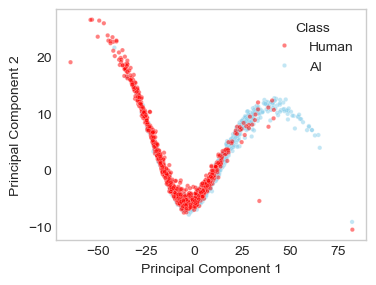

In [42]:
# Create the scatter plot
plt.figure(figsize=(4, 3))
sns.scatterplot(
    x=X_pca_sample[:, 0], 
    y=X_pca_sample[:, 1],
    hue=y_sample,
    palette=['red', 'skyblue'], # 0: Human (red), 1: AI (skyblue)
    alpha=0.5,
    s=10
)
plt.xlabel('Principal Component 1', fontsize=10)
plt.ylabel('Principal Component 2', fontsize=10)
# Manually create legend for clarity
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Human', 'AI'], title='Class')
plt.grid(False)
plt.show()

#### 1.4.2 Embedding magnitude (ℓ2 norm)

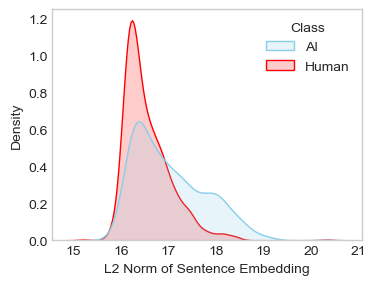

In [54]:
#  L2 Norm for each sentence vector
l2_norms = np.linalg.norm(X_pooled_sample, axis=1)
df_norms = pd.DataFrame({
    'L2_Norm': l2_norms,
    'Class': ['AI' if label == 1 else 'Human' for label in y_sample]
    })

plt.figure(figsize=(4, 3))
sns.kdeplot(
    data=df_norms, 
    x='L2_Norm', 
    hue='Class', 
    fill=True, 
    common_norm=False,
    palette={'Human': 'red', 'AI': 'skyblue'},
    alpha=0.2
    )
plt.xlabel('L2 Norm of Sentence Embedding', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.grid(False)
plt.show()

### 1.5 3D Data Preprocessing

For 1D-CNN and LSTM. 

Use **single holdout (train set - 80%,  val set - 20%)**, because these two models need quite long time to fit.

In [15]:
# split the full training dataset 
indices = []
labels = []

indices.extend([(0, i, 1) for i in range(len(ai_mmap))])
labels.extend([1] * len(ai_mmap))

indices.extend([(1, i, 0) for i in range(len(human_mmap))])
labels.extend([0] * len(human_mmap))

val_ratio = 0.2
train_indices, val_indices = train_test_split(
    indices, 
    test_size=val_ratio,
    random_state=42,
    stratify=labels
)

print(f"Total samples: {len(indices)}")
print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")

Total samples: 16322
Training samples: 13057
Validation samples: 3265


In [16]:
# data generator
def data_gen(index_list):
    for source_id, sample_id, label in index_list:
        if source_id == 0:
            yield ai_mmap[sample_id], label
        else: # source_id == 1
            yield human_mmap[sample_id], label

In [17]:
# datasets
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 5000

output_signature=(
    tf.TensorSpec(shape=(100, 768), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int32),
    )

# train set
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_gen(train_indices),
    output_signature=output_signature
).shuffle(SHUFFLE_BUFFER_SIZE, seed=42).repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# val set
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_gen(val_indices),
    output_signature=output_signature
).repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# eval set (same as val set without repeat, for evaluate the final performance)
eval_dataset = tf.data.Dataset.from_generator(
    lambda: data_gen(val_indices),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

steps_per_epoch = len(train_indices) // BATCH_SIZE
validation_steps = len(val_indices) // BATCH_SIZE

## 2. Logistic Regression

### 2.1 Baseline Logistic Regression

In [39]:
# preprocess training data with mean pooling
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                  test_size=0.2, random_state=42, 
                                                  stratify=y_train_full)

In [40]:
# train and validate the baseline model
lr_pl = Pipeline([
    ("scaler", RobustScaler()),
    ("lr", LogisticRegression(max_iter=1000, random_state=42))
    ])

lr_pl.fit(X_train, y_train)
y_val_pred_probs_base = lr_pl.predict_proba(X_val)[:, -1]
y_val_pred_labels_base = lr_pl.predict(X_val)
    
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_probs_base, pos_label=1)
auroc = auc(fpr, tpr)
acc = accuracy_score(y_val, y_val_pred_labels_base)
print(f"AUC = {auroc:.4f}, Accuracy = {acc:.4f}")

AUC = 0.9640, Accuracy = 0.8986


### 2.2 Grid Search Cross Validation

In [ ]:
# Grid Search Cross Validation
param_grid = {
    'lr__C': [0.1, 1, 10, 100], 
    'lr__solver': ['liblinear', 'saga', 'lbfgs']
    }

lr_pl = Pipeline([
        ("scaler", RobustScaler()),
        ("lr", LogisticRegression(max_iter=5000, random_state=42))
    ])

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=lr_pl,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv_splitter,
    verbose=1,
    n_jobs=-1
    )

grid_search.fit(X_train_full, y_train_full)   # 9m40s

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'lr__C': [0.1, 1, ...], 'lr__solver': ['liblinear', 'saga', ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,with_centering,True


In [25]:
# results
print("\n--- Logistic Regression Grid Search Results ---")
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[[
    'param_lr__C', 
    'param_lr__solver', 
    'mean_test_score'
]].sort_values(by='mean_test_score', ascending=False))

# get the best model
best_lr = grid_search.best_estimator_
print(f"\n Best AUC = {grid_search.best_score_:.4f}")


--- Logistic Regression Grid Search Results ---
    param_lr__C param_lr__solver  mean_test_score
0           0.1        liblinear         0.966735
2           0.1            lbfgs         0.966711
1           0.1             saga         0.966458
7          10.0             saga         0.966428
10        100.0             saga         0.966428
4           1.0             saga         0.966427
3           1.0        liblinear         0.965546
5           1.0            lbfgs         0.965540
8          10.0            lbfgs         0.963929
6          10.0        liblinear         0.963856
11        100.0            lbfgs         0.963383
9         100.0        liblinear         0.963363

 Best AUC = 0.9667


### 2.3 Validate on the Validation Dataset

#### 2.3.1 Sentence-level Results

In [27]:
# get the prepared validation data
X_val_sentences, y_val_sentences_true, y_val_paragraphs_true, paragraph_lengths, df_val_index = get_prepared_val_data(process_with_mean)

Load 20 validation paragraphs.
Data prepared for prediction. Shape: (220, 768)


In [28]:
# predict the sentences
y_val_sentences_pred_prob, y_val_sentences_pred_label, paragraph_sentence_probs = predict_val_sentences(X_val_sentences, 
                                                                                                        paragraph_lengths, 
                                                                                                        df_val_index, 
                                                                                                        best_lr, "lr")

Validation prediction complete.


In [29]:
# auc and acc
sentence_level_auc = roc_auc_score(y_val_sentences_true, y_val_sentences_pred_prob)
sentence_level_acc = accuracy_score(y_val_sentences_true, y_val_sentences_pred_label)
print(f"AUC = {sentence_level_auc:.4f}, Accuracy = {sentence_level_acc:.4f}")

AUC = 0.7688, Accuracy = 0.6682


#### 2.3.2 Paragraph-level Results

**Evaluate Different Aggregation Strategies for Paragraph Prediction**

In [45]:
# aggregation strategies
aggregation_functions = {
    "Mean": np.mean,
    "Max": np.max,
    "Min": np.min,
    "Median": np.median,
    "Standard Deviation": np.std,
    "75th Percentile": lambda p: np.percentile(p, 75),
    "Mean of Top-3": lambda p: np.mean(sorted(p)[-3:]) if len(p) >= 3 else np.mean(p)
}

In [33]:
# select the best aggregation strategy for paragraph prediction
evaluate_aggregation_methods(aggregation_functions, paragraph_sentence_probs, y_val_paragraphs_true, df_val_index)


--- Paragraph-level Results ---
Method: Mean                 | AUC = 0.9300, Accuracy = 0.7000
Method: Max                  | AUC = 0.7300, Accuracy = 0.6000
Method: Min                  | AUC = 0.9000, Accuracy = 0.5000
Method: Median               | AUC = 0.9800, Accuracy = 0.7000
Method: Standard Deviation   | AUC = 0.6700, Accuracy = 0.5000
Method: 75th Percentile      | AUC = 0.9300, Accuracy = 0.8000
Method: Mean of Top-3        | AUC = 0.8500, Accuracy = 0.7000


**Conclusion:**

Based on the AUC and Accuracy results, the best aggregation strategy for Logistic Regression is **Median.**


### 2.4 Retrain the Best Logistic Regression on the Full Training and Validation Datasets

On the entire training and validation datasets.

In [33]:
# concat datasets
X_big_train, y_big_train = concat_train_and_validation(X_train_full, X_val_sentences, y_train_full, y_val_sentences_true)

In [34]:
# retrain
best_lr.fit(X_big_train, y_big_train)

,steps,"[('scaler', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True
,unit_variance,False
,penalty,'l2'
,dual,False


In [35]:
# save the final model
import joblib

final_lr_filename = 'final_lr.joblib'
joblib.dump(best_lr, final_lr_filename)
print(f"{final_lr_filename} saved successfully!")

final_lr.joblib saved successfully!


### 2.5 Predict the Test Data

In [ ]:
# predict using median aggregation
generate_submission(best_lr, "lr", "lr_best.csv", pooling_method=process_with_mean, aggregation_method=np.median)

--- Starting prediction for model: LR ---
Pooling method: process_with_mean
Aggregation method: median
Load 180 test paragraphs

Submission file 'lr_best.csv' successfully created.


**Kaggle Result: 0.94084**

This is the baseline LR final result.

## 3. MLP

### 3.1 Baseline MLP

In [20]:
# a simple mlp model
def build_simple_mlp(input_shape=(768,)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu', name='hidden_layer_1'),
        layers.Dropout(0.3, name='dropout_1'),
        layers.Dense(64, activation='relu', name='hidden_layer_2'),
        layers.Dropout(0.3, name='dropout_2'),
        layers.Dense(1, activation='sigmoid', name='output_layer')
    ], name='Baseline_MLP')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[AUC(name='auc')]
    )
    return model

In [21]:
# split the full training data to train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)
print(f"training data: {X_train.shape}, validation data: {X_val.shape}")

training data: (13057, 768), validation data: (3265, 768)


In [31]:
# baseline mlp
base_mlp = build_simple_mlp()
base_mlp.summary()

Model: "Baseline_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,753 (417.00 KB)

 Trainable params: 106,753 (417.00 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    patience=10,
    mode='max',
    restore_best_weights=True
    )

base_mlp_history = base_mlp.fit(
    X_train, y_train, 
    epochs=50, 
    validation_data=(X_val, y_val),
    batch_size=32, 
    verbose=1,
    callbacks=[early_stopping]
    )

Epoch 1/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8749 - loss: 0.4449 - val_auc: 0.9370 - val_loss: 0.3314
Epoch 2/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9279 - loss: 0.3427 - val_auc: 0.9478 - val_loss: 0.3182
Epoch 3/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9376 - loss: 0.3190 - val_auc: 0.9508 - val_loss: 0.2895
Epoch 4/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9419 - loss: 0.3087 - val_auc: 0.9523 - val_loss: 0.2964
Epoch 5/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9440 - loss: 0.3026 - val_auc: 0.9543 - val_loss: 0.2770
Epoch 6/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9487 - loss: 0.2900 - val_auc: 0.9561 - val_loss: 0.2720
Epoch 7/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9495 - loss: 0.2873 - val_auc: 0.9542 - val_loss: 0.2815
Epoch 8/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9521 - loss: 0.2800 - val_auc: 0.9568 - val_loss: 0.2721
Epoch 9/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - au

In [35]:
# baseline results
base_mlp.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[AUC(name='auc'), 'accuracy'] # auc, accuracy
    )
base_mlp_results = base_mlp.evaluate(X_val, y_val)
print(f"AUC = {base_mlp_results[1]:.4f}, Accuracy = {base_mlp_results[2]:.4f}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.8910 - auc: 0.9622 - loss: 0.2567
AUC = 0.9622, Accuracy = 0.8910


### 3.2 Random Search Single Holdout

In [55]:
# build mlp with random layers, neurons, dropout rates
def build_model_for_tuner(hp):
    """
    build a flexible mlp
    """
    model = models.Sequential()
    model.add(layers.Input(shape=(768,)))
    
    n_hidden_layers = hp.Int('n_hidden_layers', min_value=1, max_value=4, step=1)
    dropout_rate = hp.Choice('dropout_rate', values=[0.1, 0.3, 0.5])
    for i in range(n_hidden_layers):
        if i == 0:
            n_neurons = hp.Choice(f'n_neurons_layer_{i}', values=[256, 512])
        elif i == 1:
            n_neurons = hp.Choice(f'n_neurons_layer_{i}', values=[128, 256])
        elif i == 2:
            n_neurons = hp.Choice(f'n_neurons_layer_{i}', values=[64, 128])
        else:
            n_neurons = hp.Choice(f'n_neurons_layer_{i}', values=[32, 64])
        model.add(layers.Dense(n_neurons, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[AUC(name='auc')]
    )
    return model

In [56]:
# define random search
import keras_tuner as kt

tuner = kt.RandomSearch(
    build_model_for_tuner,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=50,
    executions_per_trial=1, 
    directory='keras_tuner_logs',
    project_name='ai_vs_human_sigmoid',
    overwrite=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',   # monitor auc
    patience=10,
    mode='max',
    restore_best_weights=True
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
n_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
dropout_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.3, 0.5], 'ordered': True}
n_neurons_layer_0 (Choice)
{'default': 256, 'conditions': [], 'values': [256, 512], 'ordered': True}


In [57]:
# random search
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
    )

Trial 50 Complete [00h 00m 43s]
val_auc: 0.9620897769927979

Best val_auc So Far: 0.9638357162475586
Total elapsed time: 00h 48m 02s


In [58]:
# top results
tuner.results_summary(num_trials=3)

Results summary
Results in keras_tuner_logs/ai_vs_human_sigmoid
Showing 3 best trials
Objective(name="val_auc", direction="max")

Trial 03 summary
Hyperparameters:
n_hidden_layers: 2
dropout_rate: 0.3
n_neurons_layer_0: 512
n_neurons_layer_1: 128
n_neurons_layer_2: 64
n_neurons_layer_3: 64
Score: 0.9638357162475586

Trial 08 summary
Hyperparameters:
n_hidden_layers: 3
dropout_rate: 0.1
n_neurons_layer_0: 256
n_neurons_layer_1: 256
n_neurons_layer_2: 128
n_neurons_layer_3: 64
Score: 0.963479220867157

Trial 37 summary
Hyperparameters:
n_hidden_layers: 1
dropout_rate: 0.1
n_neurons_layer_0: 512
n_neurons_layer_1: 128
n_neurons_layer_2: 64
n_neurons_layer_3: 32
Score: 0.9632481932640076


In [59]:
# best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# model information
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_trial = tuner.oracle.get_best_trials(1)[0]
best_epoch = best_trial.best_step
print(f"In Random Search, the best val score occurs at epoch {best_epoch}.")

/opt/anaconda3/envs/caiml/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,521 (1.75 MB)

 Trainable params: 459,521 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In Random Search, the best val score occurs at epoch 49.


### 3.3 Retrain the Best MLP on the Full Training Dataset

Because we use single handout to select the best model, we retrain the model on the full training dataset.

In [87]:
# shuffle the full training data
X_train_full_shuffled, y_train_full_shuffled = shuffle(X_train_full, y_train_full, random_state=42)

In [88]:
# retrain
best_mlp = build_best_mlp()
best_mlp.fit(
    X_train_full_shuffled, y_train_full_shuffled,
    epochs=best_epoch,
    verbose=1
    )

Epoch 1/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.8878 - loss: 0.4214
Epoch 2/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9326 - loss: 0.3320
Epoch 3/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9434 - loss: 0.3043
Epoch 4/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9464 - loss: 0.2963
Epoch 5/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9501 - loss: 0.2860
Epoch 6/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.9507 - loss: 0.2840
Epoch 7/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9529 - loss: 0.2777
Epoch 8/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9542 - loss: 0.2737
Epoch 9/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9555 - loss: 0.2696
Epoch 10/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9564 - loss: 0.2667
Epoch 11/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9577 - loss: 0.2627
Epoch 12/49
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9575 - loss: 0.2633
Epoch 13/49
511/511 ━━━━━

### 3.4 Validate on the Validation Dataset

#### 3.4.1 Sentence-level Results

In [90]:
# get the prepared validation data
X_val_sentences, y_val_sentences_true, y_val_paragraphs_true, paragraph_lengths, df_val_index = get_prepared_val_data(process_with_mean)

Load 20 validation paragraphs.
Data prepared for prediction. Shape: (220, 768)


In [91]:
# predict the sentences
y_val_sentences_pred_prob, y_val_sentences_pred_label, paragraph_sentence_probs = predict_val_sentences(X_val_sentences, 
                                                                                                        paragraph_lengths, 
                                                                                                        df_val_index, 
                                                                                                        best_mlp, "mlp")

Validation prediction complete.


In [92]:
# auc and acc
sentence_level_auc = roc_auc_score(y_val_sentences_true, y_val_sentences_pred_prob)
sentence_level_acc = accuracy_score(y_val_sentences_true, y_val_sentences_pred_label)
print(f"AUC = {sentence_level_auc:.4f}, Accuracy = {sentence_level_acc:.4f}")

AUC = 0.7870, Accuracy = 0.7364


#### 3.4.2 Paragraph-level Results

**Evaluate Different Aggregation Strategies for Paragraph Prediction**

In [96]:
# select the best aggregation strategy for paragraph prediction
evaluate_aggregation_methods(aggregation_functions, paragraph_sentence_probs, y_val_paragraphs_true, df_val_index)


--- Paragraph-level Results ---
Method: Mean                 | AUC = 1.0000, Accuracy = 0.7500
Method: Max                  | AUC = 0.8300, Accuracy = 0.5500
Method: Min                  | AUC = 0.8900, Accuracy = 0.5500
Method: Median               | AUC = 1.0000, Accuracy = 0.7500
Method: Standard Deviation   | AUC = 0.7600, Accuracy = 0.5000
Method: 75th Percentile      | AUC = 0.9900, Accuracy = 0.9500
Method: Mean of Top-3        | AUC = 0.9600, Accuracy = 0.7000


**Conclusion:**

Based on the AUC results, the best aggregation strategy for MLP is **Mean.**


### 3.5 Retrain the Best MLP on the Full Training and Validation Datasets

In [102]:
# concat datasets
X_big_train, y_big_train = concat_train_and_validation(X_train_full, X_val_sentences, y_train_full, y_val_sentences_true)

In [103]:
# rebuild the best model and retrain
final_mlp = build_best_mlp()
final_mlp.fit(X_big_train, y_big_train, epochs=best_epoch, verbose=1)

Epoch 1/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.8880 - loss: 0.4227
Epoch 2/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9356 - loss: 0.3258
Epoch 3/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9410 - loss: 0.3107
Epoch 4/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9449 - loss: 0.3005
Epoch 5/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9483 - loss: 0.2912
Epoch 6/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9498 - loss: 0.2862
Epoch 7/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.9514 - loss: 0.2820
Epoch 8/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9527 - loss: 0.2778
Epoch 9/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9540 - loss: 0.2746
Epoch 10/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9539 - loss: 0.2746
Epoch 11/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9554 - loss: 0.2697
Epoch 12/49
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9553 - loss: 0.2697
Epoch 13/49
517/517 ━━━━━

In [104]:
# save model
model_filename = 'final_mlp.keras'
final_mlp.save(model_filename)
print(f"{model_filename} saved successfully.")

final_mlp.keras saved successfully.


### 3.6 Predict the Test Data

In [105]:
# preprocess data with mean pooling, predict paragraph probs with mean aggregation
generate_submission(final_mlp, "mlp", "mlp_best.csv", pooling_method=process_with_mean, aggregation_method=np.mean)

--- Starting prediction for model: MLP ---
Pooling method: process_with_mean
Aggregation method: mean
Load 180 test paragraphs

Submission file 'mlp_best.csv' successfully created.


**Kaggle Result: 0.94499**

MLP performs better than logistic regression.

## 4. XGBoost

### 4.1 Baseline XGBoost

In [ ]:
# split the full training to train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

In [ ]:
# train and validate the baseline model
import xgboost as xgb

base_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                             eval_metric='logloss', 
                             random_state=42, 
                             early_stopping_rounds=10)    
base_xgb.fit(X_train, y_train, 
             eval_set=[(X_val, y_val)], 
             verbose=False)
    
y_val_pred_probs = base_xgb.predict_proba(X_val)[:, 1]
y_val_pred_labels = base_xgb.predict(X_val)

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_probs, pos_label=1)
auroc = auc(fpr, tpr)
acc = accuracy_score(y_val, y_val_pred_labels)
print(f"AUC = {auroc:.4f}, Accuracy = {acc:.4f}")

AUC = 0.9409, Accuracy = 0.8674


### 4.2 Random Search Cross Validation

In [ ]:
# Random Search Cross-Validation
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
    }

xgb_search = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss', 
    random_state=42
    )

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_search,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
    )

random_search.fit(X_train_full, y_train_full)
print(f"\nRandom search done.")

Fitting 5 folds for each of 50 candidates, totalling 250 fits



Random search done.


In [100]:
# results
print("\n---  Grid Search Results ---")
print(f"Best AUC: {random_search.best_score_:.4f}")
print("Best Params:")
for param, value in random_search.best_params_.items():
    print(f"  - {param}: {value}")

best_xgb = random_search.best_estimator_
best_params = random_search.best_params_


---  Grid Search Results ---
Best AUC: 0.9585
Best Params:
  - subsample: 1.0
  - n_estimators: 500
  - max_depth: 6
  - learning_rate: 0.2
  - gamma: 0
  - colsample_bytree: 0.8


### 4.3 Validate on the Validation Dataset

#### 4.3.1 Sentence-level Results

In [102]:
# get the prepared validation data
X_val_sentences, y_val_sentences_true, y_val_paragraphs_true, paragraph_lengths, df_val_index = get_prepared_val_data(process_with_mean)

Load 20 validation paragraphs.
Data prepared for prediction. Shape: (220, 768)


In [104]:
# predict the sentences
y_val_sentences_pred_prob, y_val_sentences_pred_label, paragraph_sentence_probs = predict_val_sentences(X_val_sentences, 
                                                                                                        paragraph_lengths, 
                                                                                                        df_val_index, 
                                                                                                        best_xgb, "xgboost")

Validation prediction complete.


In [105]:
# auc and acc
sentence_level_auc = roc_auc_score(y_val_sentences_true, y_val_sentences_pred_prob)
sentence_level_acc = accuracy_score(y_val_sentences_true, y_val_sentences_pred_label)
print(f"AUC = {sentence_level_auc:.4f}, Accuracy = {sentence_level_acc:.4f}")

AUC = 0.7697, Accuracy = 0.7045


#### 4.3.2 Paragraph-level Results

**Evaluate Different Aggregation Strategies for Paragraph Prediction**

In [109]:
# select the best aggregation strategy for paragraph prediction
evaluate_aggregation_methods(aggregation_functions, paragraph_sentence_probs, y_val_paragraphs_true, df_val_index)


--- Paragraph-level Results ---
Method: Mean                 | AUC = 0.9600, Accuracy = 0.7500
Method: Max                  | AUC = 0.6800, Accuracy = 0.5000
Method: Min                  | AUC = 0.9100, Accuracy = 0.6000
Method: Median               | AUC = 0.9700, Accuracy = 0.7500
Method: Standard Deviation   | AUC = 0.7300, Accuracy = 0.5000
Method: 75th Percentile      | AUC = 0.9600, Accuracy = 0.9000
Method: Mean of Top-3        | AUC = 0.9200, Accuracy = 0.7000


**Conclusion:**

Based on the AUC results, the best aggregation strategy for XGBoost is **Median.**

### 4.4 Retrain the Best XGBoost on the Full Training and Validation Datasets

In [120]:
# concat datasets
X_big_train, y_big_train = concat_train_and_validation(X_train_full, X_val_sentences, y_train_full, y_val_sentences_true)

In [121]:
# retrain the best XGB
final_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
final_xgb.set_params(**best_params)
final_xgb.fit(X_big_train, y_big_train, verbose=False) #

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [122]:
# save model
final_xgb_filename = "final_xgb.ubj"
final_xgb.save_model(final_xgb_filename)
print(f"{final_xgb_filename} saved successfully.")

final_xgb.ubj saved successfully.


### 4.5 Predict the Test Data

In [123]:
# preprocess data with mean pooling, predict paragraph probs with median aggregation
generate_submission(final_xgb, "xgboost", "xgb_best.csv", pooling_method=process_with_mean, aggregation_method=np.median)

--- Starting prediction for model: XGBOOST ---
Pooling method: process_with_mean
Aggregation method: median
Load 180 test paragraphs

Submission file 'xgb_best.csv' successfully created.


**Kaggle Result: 0.91852**

XGBoost performs worse than baseline model logistic regression, and we will not use it.

## 5. 1D-CNN

### 5.1 Baseline CNN

In [17]:
# build a simple 1d-cnn
def build_cnn(input_shape=(100, 768)):
    model = models.Sequential([
        layers.Input(shape=input_shape, name="Input_Layer"),
        layers.Conv1D(filters=128, kernel_size=5, activation='relu', name="Conv1D_Layer"),
        layers.GlobalMaxPooling1D(name="GlobalMaxPooling_Layer"),
        layers.Dropout(0.5, name="Dropout_Layer"),
        layers.Dense(64, activation='relu', name="Dense_Layer"),
        layers.Dense(1, activation='sigmoid', name="Output_Layer")
    ], name="Baseline_CNN")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[AUC(name='auc')]
    )
    return model

In [18]:
# cnn summary
base_cnn = build_cnn()
base_cnn.summary()

Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_Layer (Conv1D)           │ (None, 96, 128)        │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalMaxPooling_Layer          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,969 (1.91 MB)

 Trainable params: 499,969 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    patience=10,
    mode='max',
    restore_best_weights=True
    )

base_cnn_history = base_cnn.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=[early_stopping]
    )

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - auc: 0.8590 - loss: 0.4692 - val_auc: 0.9229 - val_loss: 0.3809
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - auc: 0.9098 - loss: 0.3820 - val_auc: 0.9384 - val_loss: 0.3270
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - auc: 0.9198 - loss: 0.3607 - val_auc: 0.9382 - val_loss: 0.3468
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - auc: 0.9362 - loss: 0.3231 - val_auc: 0.9493 - val_loss: 0.2950
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - auc: 0.9390 - loss: 0.3159 - val_auc: 0.9536 - val_loss: 0.3099
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - auc: 0.9378 - loss: 0.3184 - val_auc: 0.9546 - val_loss: 0.2749
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - auc: 0.9441 - loss: 0.3007 - val_auc: 0.9537 - val_loss: 0.2978
Epoch 8/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - auc: 0.9457 - loss: 0.2980 - val_auc: 0.9517 - val_loss: 0.3056
Epoch 9/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:
# baseline results
base_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[AUC(name='auc'), 'accuracy'] # auc, accuracy
)

base_cnn_results = base_cnn.evaluate(eval_dataset)
print(f"AUC = {base_cnn_results[1]:.4f}, Accuracy = {base_cnn_results[2]:.4f}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9008 - auc: 0.9646 - loss: 0.2870
AUC = 0.9646, Accuracy = 0.9008


### 5.2 Random Search Single Holdout

In [ ]:
def build_cnn_tuner(hp):
    """build a 1d-cnn with different num of filters, kernel size, dropout rate, dense units and learning rate"""
    
    model = models.Sequential(name="Optimized_CNN")
    model.add(layers.Input(shape=(100, 768), name="Input_Layer"))
    # Conv1D filters, kernel_size
    hp_filters = hp.Choice('filters', values=[64, 128, 256])
    hp_kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
    model.add(layers.Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation='relu', name="Conv1D_Layer"))
    model.add(layers.GlobalMaxPooling1D(name="GlobalMaxPooling_Layer"))
    # dropout_rate
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(layers.Dropout(hp_dropout_rate, name="Dropout_Layer"))
    # dense_units
    hp_dense_units = hp.Choice('dense_units', values=[32, 64, 128])
    model.add(layers.Dense(hp_dense_units, activation='relu', name="Dense_Layer"))
    model.add(layers.Dense(1, activation='sigmoid', name="Output_Layer"))
    # learning_rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=[AUC(name='auc')]
    )
    
    return model

In [27]:
# Random Search
import keras_tuner as kt

tuner = kt.RandomSearch(
    build_cnn_tuner,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=10,
    executions_per_trial=1, 
    directory='keras_tuner_logs',
    project_name='cnn',
    overwrite=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',   # monitor auc
    patience=10,
    mode='max',
    restore_best_weights=True
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
filters (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [28]:
tuner.search(
    train_dataset,
    epochs=50,
    steps_per_epoch=len(train_indices) // BATCH_SIZE, 
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
    )  # 158min

Trial 10 Complete [00h 12m 08s]
val_auc: 0.968439519405365

Best val_auc So Far: 0.969817042350769
Total elapsed time: 02h 37m 56s


In [29]:
# top results
tuner.results_summary(num_trials=3)

Results summary
Results in keras_tuner_logs/cnn
Showing 3 best trials
Objective(name="val_auc", direction="max")

Trial 08 summary
Hyperparameters:
filters: 128
kernel_size: 7
dropout_rate: 0.4
dense_units: 128
learning_rate: 0.0001
Score: 0.969817042350769

Trial 02 summary
Hyperparameters:
filters: 64
kernel_size: 5
dropout_rate: 0.30000000000000004
dense_units: 32
learning_rate: 0.0001
Score: 0.9693890810012817

Trial 04 summary
Hyperparameters:
filters: 64
kernel_size: 3
dropout_rate: 0.2
dense_units: 64
learning_rate: 0.001
Score: 0.9692404270172119


In [31]:
# best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# model information
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_trial = tuner.oracle.get_best_trials(1)[0]
best_epoch = best_trial.best_step
print(f"The best val score occurs at epoch {best_epoch}.")

Model: "Optimized_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_Layer (Conv1D)           │ (None, 94, 128)        │       688,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalMaxPooling_Layer          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer (Dense)             │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,897 (2.69 MB)

 Trainable params: 704,897 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

The best val score occurs at epoch 42.


### 5.3 Retrain the Best CNN on the Full Training Dataset

In [ ]:
# full training dataset
full_train_indices = []
full_train_indices.extend([(0, i, 1) for i in range(len(ai_mmap))]) # AI
full_train_indices.extend([(1, i, 0) for i in range(len(human_mmap))]) # Human
full_train_dataset = tf.data.Dataset.from_generator(
    lambda: data_gen(full_train_indices),
    output_signature=output_signature
)

num_samples = len(full_train_indices)
full_train_dataset = full_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE, seed=RANDOM_SEED).repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
steps_per_epoch = num_samples // BATCH_SIZE

In [115]:
# rebuild the best model and retrain
best_cnn = tuner.hypermodel.build(best_hps)
best_cnn.fit(full_train_dataset, 
              epochs=best_epoch, 
              steps_per_epoch=steps_per_epoch, 
              verbose=1)  # 20min7s

Epoch 1/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - auc: 0.9323 - loss: 0.3324
Epoch 2/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - auc: 0.9515 - loss: 0.2840
Epoch 3/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - auc: 0.9618 - loss: 0.2508
Epoch 4/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - auc: 0.9659 - loss: 0.2375
Epoch 5/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - auc: 0.9693 - loss: 0.2249
Epoch 6/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 29s 56ms/step - auc: 0.9723 - loss: 0.2128
Epoch 7/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - auc: 0.9719 - loss: 0.2146
Epoch 8/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - auc: 0.9737 - loss: 0.2076
Epoch 9/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - auc: 0.9743 - loss: 0.2045
Epoch 10/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - auc: 0.9753 - loss: 0.2010
Epoch 11/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - auc: 0.9764 - loss: 0.1949
Epoch 12/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - auc: 0.9780 - loss: 0.1890
E

### 5.4 Validate on the Validation Dataset

#### 5.4.1 Sentence-level Results

In [117]:
# get the prepared validation data
X_val_sentences, y_val_sentences_true, y_val_paragraphs_true, paragraph_lengths, df_val_index = get_prepared_val_data()

Load 20 validation paragraphs.
Data prepared for prediction. Shape: (220, 100, 768)


In [118]:
# predict the sentences
y_val_sentences_pred_prob, y_val_sentences_pred_label, paragraph_sentence_probs = predict_val_sentences(X_val_sentences, 
                                                                                                        paragraph_lengths, 
                                                                                                        df_val_index, 
                                                                                                        best_cnn, "cnn")

Validation prediction complete.


In [119]:
# auc and acc
sentence_level_auc = roc_auc_score(y_val_sentences_true, y_val_sentences_pred_prob)
sentence_level_acc = accuracy_score(y_val_sentences_true, y_val_sentences_pred_label)
print(f"AUC = {sentence_level_auc:.4f}, Accuracy = {sentence_level_acc:.4f}")

AUC = 0.7646, Accuracy = 0.6818


#### 5.4.2 Paragraph-level Results

**Evaluate Different Aggregation Strategies for Paragraph Prediction**

In [123]:
# select the best aggregation strategy for paragraph prediction
evaluate_aggregation_methods(aggregation_functions, paragraph_sentence_probs, y_val_paragraphs_true, df_val_index)


--- Paragraph-level Results ---
Method: Mean                 | AUC = 0.9700, Accuracy = 0.7000
Method: Max                  | AUC = 0.8800, Accuracy = 0.6500
Method: Min                  | AUC = 0.8600, Accuracy = 0.5000
Method: Median               | AUC = 0.9500, Accuracy = 0.7000
Method: Standard Deviation   | AUC = 0.8800, Accuracy = 0.5000
Method: 75th Percentile      | AUC = 0.9600, Accuracy = 0.9000
Method: Mean of Top-3        | AUC = 0.9500, Accuracy = 0.9000


**Conclusion:**

Based on the AUC results, the best aggregation strategy for 1D-CNN is **Mean.**


### 5.5 Retrain the Best CNN on the Full Training Dataset and Validation Dataset

In [53]:
# combine the full training and validation datasets

# full training dataset
full_train_indices = []
full_train_indices.extend([(0, i, 1) for i in range(len(ai_mmap))]) # AI
full_train_indices.extend([(1, i, 0) for i in range(len(human_mmap))]) # Human
full_train_dataset = tf.data.Dataset.from_generator(
    lambda: data_gen(full_train_indices),
    output_signature=output_signature
)

# validation dataset
real_val_dataset = tf.data.Dataset.from_tensor_slices((X_val_sentences, y_val_sentences_true))

# big train dataset
big_train_dataset = full_train_dataset.concatenate(real_val_dataset)
total_samples = len(full_train_indices) + len(X_val_sentences)
print(f"Total samples: {total_samples}")

big_train_dataset = big_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE, seed=42).repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

steps_per_epoch = total_samples // BATCH_SIZE

Total samples: 16542


In [54]:
# rebuild the best model and retrain
final_cnn = tuner.hypermodel.build(best_hps)
final_cnn.fit(big_train_dataset, 
              epochs=best_epoch, 
              steps_per_epoch=steps_per_epoch, 
              verbose=1)  # 20min7s

Epoch 1/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - auc: 0.9285 - loss: 0.3422
Epoch 2/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - auc: 0.9458 - loss: 0.2998
Epoch 3/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - auc: 0.9578 - loss: 0.2637
Epoch 4/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - auc: 0.9620 - loss: 0.2504
Epoch 5/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - auc: 0.9652 - loss: 0.2395
Epoch 6/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - auc: 0.9684 - loss: 0.2268
Epoch 7/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - auc: 0.9688 - loss: 0.2256
Epoch 8/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 29s 56ms/step - auc: 0.9711 - loss: 0.2170
Epoch 9/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 28s 53ms/step - auc: 0.9727 - loss: 0.2105
Epoch 10/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - auc: 0.9730 - loss: 0.2095
Epoch 11/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - auc: 0.9746 - loss: 0.2018
Epoch 12/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - auc: 0.9753 - loss: 0.1989
E

In [55]:
# save model
model_filename = 'final_cnn.keras'
final_cnn.save(model_filename)
print(f"{model_filename} saved successfully.")

final_cnn.keras saved successfully.


### 5.6 Predict the Test Data

In [56]:
# predict paragraph probs with mean aggregation
generate_submission(final_cnn, "cnn", "cnn_best.csv", pooling_method=None, aggregation_method=np.mean)

--- Starting prediction for model: CNN ---
Pooling method: None
Aggregation method: mean
Load 180 test paragraphs

Submission file 'cnn_best.csv' successfully created.


**Kaggle Result: 0.95433**

1D-CNN performs better than the baseline logistic regression.

## 6. LSTM

### 6.1 Baseline LSTM

In [68]:
# build a simple lstm
def build_lstm(input_shape=(100, 768)):
    model = models.Sequential([
        layers.Input(shape=input_shape, name="Input_Layer"),
        layers.LSTM(128, return_sequences=False, name="LSTM_Layer"),
        layers.Dropout(0.5, name="Dropout_Layer"),
        layers.Dense(64, activation='relu', name="Dense_Layer"),
        layers.Dense(1, activation='sigmoid', name="Output_Layer")
    ], name='Baseline_LSTM')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    
    return model

In [19]:
# lstm summary
base_lstm = build_lstm()
base_lstm.summary()

Model: "Baseline_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer (LSTM)               │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,585 (1.78 MB)

 Trainable params: 467,585 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    patience=10,
    mode='max',
    restore_best_weights=True
    )

base_lstm_history = base_lstm.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=[early_stopping]
    ) # 45m40s

Epoch 1/50


408/408 ━━━━━━━━━━━━━━━━━━━━ 51s 122ms/step - accuracy: 0.5162 - auc: 0.5318 - loss: 0.6905 - val_accuracy: 0.5028 - val_auc: 0.5025 - val_loss: 0.6920
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 56s 137ms/step - accuracy: 0.5094 - auc: 0.5163 - loss: 0.6875 - val_accuracy: 0.5089 - val_auc: 0.5119 - val_loss: 0.6910
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 56s 137ms/step - accuracy: 0.5070 - auc: 0.5076 - loss: 0.6936 - val_accuracy: 0.5003 - val_auc: 0.5018 - val_loss: 0.6936
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 55s 136ms/step - accuracy: 0.4941 - auc: 0.4943 - loss: 0.6937 - val_accuracy: 0.5067 - val_auc: 0.5021 - val_loss: 0.6929
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 143ms/step - accuracy: 0.5263 - auc: 0.5445 - loss: 0.6850 - val_accuracy: 0.7286 - val_auc: 0.7744 - val_loss: 0.5678
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 57s 141ms/step - accuracy: 0.7682 - auc: 0.8190 - loss: 0.5183 - val_accuracy: 0.7947 - val_auc: 0.8835 - val_loss: 0.4927
Epoch 7/50
408/408 ━━━━━━━━━━━━━━

In [22]:
# baseline results
base_lstm_results = base_lstm.evaluate(eval_dataset)
print(f"AUC = {base_lstm_results[2]:.4f}, Accuracy = {base_lstm_results[1]:.4f}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9017 - auc: 0.9670 - loss: 0.2361
AUC = 0.9670, Accuracy = 0.9017


### 6.2 Random Search Single Holdout

In [ ]:
def build_lstm_tuner(hp):
    """
    build a flexible lstm model with multiple lstm layers and bidirection
    """
    model = models.Sequential(name="Optimized_LSTM")
    model.add(layers.Input(shape=(100, 768), name="Input_Layer"))
    
    # stack or not
    hp_stacked = hp.Boolean("stacked_lstm")
    # bidirectional or not
    hp_bidirectional = hp.Boolean("bidirectional")
    # lstm layer1 units
    lstm_layer_1 = layers.LSTM(
        units=hp.Choice('lstm_units_1', values=[64, 128, 256]),
        return_sequences=hp_stacked, 
        name="LSTM_Layer_1"
    )
    
    if hp_bidirectional:
        model.add(layers.Bidirectional(lstm_layer_1, name="Bidirectional_LSTM_1"))
    else:
        model.add(lstm_layer_1)

    if hp_stacked:
        # lstm layer2 units
        lstm_layer_2 = layers.LSTM(
            units=hp.Choice('lstm_units_2', values=[32, 64, 128]),
            return_sequences=False,
            name="LSTM_Layer_2"
        )
        if hp_bidirectional:
            model.add(layers.Bidirectional(lstm_layer_2, name="Bidirectional_LSTM_2"))
        else:
            model.add(lstm_layer_2)

    # dropout rate
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(layers.Dropout(hp_dropout_rate, name="Dropout_Layer"))
    
    # dense units
    hp_dense_units = hp.Choice('dense_units', values=[32, 64, 128])
    model.add(layers.Dense(hp_dense_units, activation='relu', name="Dense_Layer"))
    model.add(layers.Dense(1, activation='sigmoid', name="Output_Layer"))
    
    # learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    
    return model

In [86]:
# define tuner
import keras_tuner as kt

tuner = kt.RandomSearch(
    build_lstm_tuner,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=10,
    executions_per_trial=1, 
    directory='keras_tuner_logs',
    project_name='lstm',
    overwrite=True
)

tuner.search_space_summary()

Search space summary
Default search space size: 6
stacked_lstm (Boolean)
{'default': False, 'conditions': []}
bidirectional (Boolean)
{'default': False, 'conditions': []}
lstm_units_1 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [89]:
# random search
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=10,
    mode='max',
    restore_best_weights=True
)

tuner.search(
    train_dataset,
    epochs=50,
    steps_per_epoch=len(train_indices) // BATCH_SIZE, 
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
    )  # 09h 03m 03s

Trial 10 Complete [00h 50m 03s]
val_auc: 0.968315601348877

Best val_auc So Far: 0.968315601348877
Total elapsed time: 09h 03m 03s


In [90]:
# top results
tuner.results_summary(num_trials=3)

Results summary
Results in keras_tuner_logs/lstm
Showing 3 best trials
Objective(name="val_auc", direction="max")

Trial 09 summary
Hyperparameters:
stacked_lstm: True
bidirectional: False
lstm_units_1: 128
dropout_rate: 0.4
dense_units: 64
learning_rate: 0.001
lstm_units_2: 32
Score: 0.968315601348877

Trial 05 summary
Hyperparameters:
stacked_lstm: True
bidirectional: True
lstm_units_1: 256
dropout_rate: 0.30000000000000004
dense_units: 32
learning_rate: 0.001
lstm_units_2: 64
Score: 0.9682813286781311

Trial 04 summary
Hyperparameters:
stacked_lstm: False
bidirectional: True
lstm_units_1: 256
dropout_rate: 0.4
dense_units: 32
learning_rate: 0.001
lstm_units_2: 32
Score: 0.9681872129440308


In [91]:
# best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# model information
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_trial = tuner.oracle.get_best_trials(1)[0]
best_epoch = best_trial.best_step
print(f"The best val score occurs at epoch {best_epoch}.")

/opt/anaconda3/envs/caiml/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "Optimized_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer_1 (LSTM)             │ (None, 100, 128)       │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_2 (LSTM)             │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer (Dense)             │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,049 (1.84 MB)

 Trainable params: 482,049 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

The best val score occurs at epoch 42.


### 6.3 Retrain the Best LSTM on the Full Training Dataset

In [99]:
# full training dataset
full_train_indices = []
full_train_indices.extend([(0, i, 1) for i in range(len(ai_mmap))]) # AI
full_train_indices.extend([(1, i, 0) for i in range(len(human_mmap))]) # Human
full_train_dataset = tf.data.Dataset.from_generator(
    lambda: data_gen(full_train_indices),
    output_signature=output_signature
)

num_samples = len(full_train_indices)
full_train_dataset = full_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE, seed=RANDOM_SEED).repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
steps_per_epoch = num_samples // BATCH_SIZE

In [102]:
# rebuild the best model and retrain
best_lstm = tuner.hypermodel.build(best_hps)
best_lstm.fit(full_train_dataset, 
              epochs=best_epoch, 
              steps_per_epoch=steps_per_epoch, 
              verbose=1)  # 20min7s

Epoch 1/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 63s 119ms/step - accuracy: 0.7853 - auc: 0.8403 - loss: 0.4669
Epoch 2/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - accuracy: 0.7621 - auc: 0.8310 - loss: 0.4902
Epoch 3/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 56s 110ms/step - accuracy: 0.7773 - auc: 0.8355 - loss: 0.4786
Epoch 4/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.7527 - auc: 0.8062 - loss: 0.5228
Epoch 5/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 62s 121ms/step - accuracy: 0.7318 - auc: 0.7971 - loss: 0.5482
Epoch 6/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 61s 119ms/step - accuracy: 0.7431 - auc: 0.7981 - loss: 0.5396
Epoch 7/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 60s 118ms/step - accuracy: 0.7069 - auc: 0.7682 - loss: 0.5789
Epoch 8/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 63s 123ms/step - accuracy: 0.6713 - auc: 0.7242 - loss: 0.6176
Epoch 9/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 61s 119ms/step - accuracy: 0.7155 - auc: 0.7632 - loss: 0.5946
Epoch 10/42
510/510 ━━━━━━━━━━━━━━━━━━━━ 62s 122ms/step - accuracy: 0.740

### 6.4 Validate on the Validation Dataset


#### 6.4.1 Sentence-level Results

In [104]:
# get the prepared validation data
X_val_sentences, y_val_sentences_true, y_val_paragraphs_true, paragraph_lengths, df_val_index = get_prepared_val_data()

# predict the sentences
y_val_sentences_pred_prob, y_val_sentences_pred_label, paragraph_sentence_probs = predict_val_sentences(X_val_sentences, 
                                                                                                        paragraph_lengths, 
                                                                                                        df_val_index, 
                                                                                                        best_lstm, "lstm")

Load 20 validation paragraphs.
Data prepared for prediction. Shape: (220, 100, 768)
Validation prediction complete.


AUC = 0.7658, Accuracy = 0.6818
--- Classification Report ---
                 precision    recall  f1-score   support

Human (Class 0)       0.66      0.91      0.76       124
   AI (Class 1)       0.77      0.39      0.51        96

       accuracy                           0.68       220
      macro avg       0.71      0.65      0.64       220
   weighted avg       0.71      0.68      0.65       220



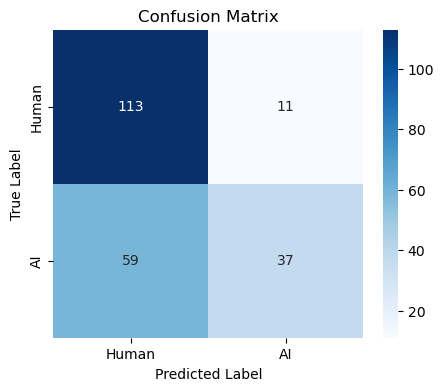

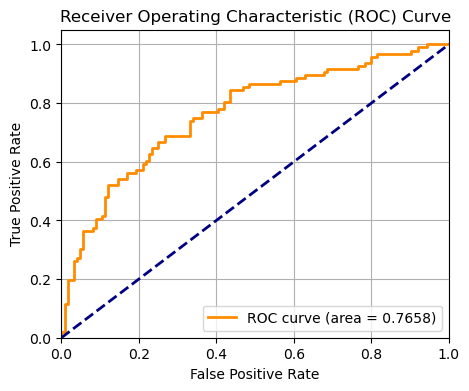

In [105]:
# auc and acc
sentence_level_auc = roc_auc_score(y_val_sentences_true, y_val_sentences_pred_prob)
sentence_level_acc = accuracy_score(y_val_sentences_true, y_val_sentences_pred_label)
print(f"AUC = {sentence_level_auc:.4f}, Accuracy = {sentence_level_acc:.4f}")

# classification report 
print("--- Classification Report ---")
print(classification_report(y_val_sentences_true, y_val_sentences_pred_label, target_names=['Human (Class 0)', 'AI (Class 1)']))

# confusion matrix
display_confusion_matrix(y_val_sentences_true, y_val_sentences_pred_label)

# roc curve
display_roc(y_val_sentences_true, y_val_sentences_pred_prob)

#### 6.4.2 Paragraph-level Results

**Evaluate Different Aggregation Strategies for Paragraph Prediction**

In [106]:
# select the best aggregation strategy for paragraph prediction
evaluate_aggregation_methods(aggregation_functions, paragraph_sentence_probs, y_val_paragraphs_true, df_val_index)


--- Paragraph-level Results ---
Method: Mean                 | AUC = 0.9500, Accuracy = 0.7000
Method: Max                  | AUC = 0.8800, Accuracy = 0.5500
Method: Min                  | AUC = 0.9200, Accuracy = 0.5000
Method: Median               | AUC = 0.9200, Accuracy = 0.7000
Method: Standard Deviation   | AUC = 0.8800, Accuracy = 0.5000
Method: 75th Percentile      | AUC = 0.9300, Accuracy = 0.8500
Method: Mean of Top-3        | AUC = 0.9100, Accuracy = 0.8500


In [107]:
# aggregate the sentence results based on the mean aggragation
y_val_paragraph_probs_pred, y_val_paragraph_labels_pred = aggregate_sentence_probs(paragraph_sentence_probs, df_val_index, np.mean)

AUC = 0.9500, Accuracy = 0.7000
--- Classification Report ---
                 precision    recall  f1-score   support

Human (Class 0)       0.62      1.00      0.77        10
   AI (Class 1)       1.00      0.40      0.57        10

       accuracy                           0.70        20
      macro avg       0.81      0.70      0.67        20
   weighted avg       0.81      0.70      0.67        20



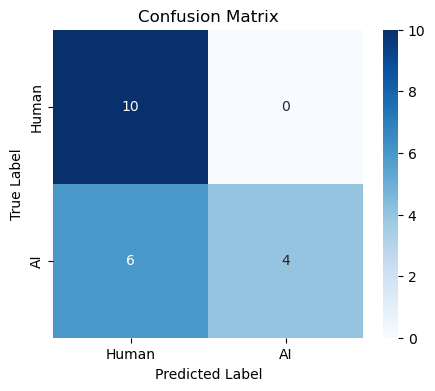

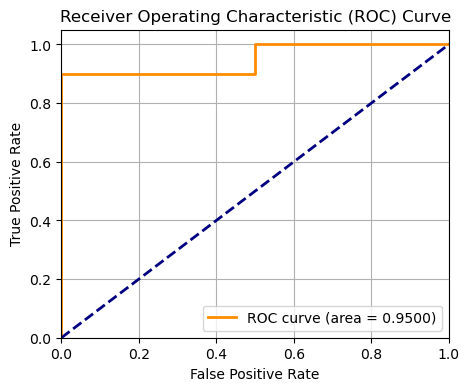

In [108]:
# auc and acc
auc_score = roc_auc_score(y_val_paragraphs_true, y_val_paragraph_probs_pred)
acc = accuracy_score(y_val_paragraphs_true, y_val_paragraph_labels_pred)
print(f"AUC = {auc_score:.4f}, Accuracy = {acc:.4f}")

# classification report 
print("--- Classification Report ---")
print(classification_report(y_val_paragraphs_true, y_val_paragraph_labels_pred, target_names=['Human (Class 0)', 'AI (Class 1)']))

# confusion matrix
display_confusion_matrix(y_val_paragraphs_true, y_val_paragraph_labels_pred)

# roc curve
display_roc(y_val_paragraphs_true, y_val_paragraph_probs_pred)


### 6.5 Retrain the Best LSTM on the Full Training and Validation Datasets

In [111]:
# combine the full training and validation datasets

# full training dataset
full_train_indices = []
full_train_indices.extend([(0, i, 1) for i in range(len(ai_mmap))]) # AI
full_train_indices.extend([(1, i, 0) for i in range(len(human_mmap))]) # Human
full_train_dataset = tf.data.Dataset.from_generator(
    lambda: data_gen(full_train_indices),
    output_signature=output_signature
)

# validation dataset
real_val_dataset = tf.data.Dataset.from_tensor_slices((X_val_sentences, y_val_sentences_true))

# big train dataset
big_train_dataset = full_train_dataset.concatenate(real_val_dataset)
total_samples = len(full_train_indices) + len(X_val_sentences)
print(f"Total samples: {total_samples}")

big_train_dataset = big_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE, seed=42).repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
steps_per_epoch = total_samples // BATCH_SIZE

Total samples: 16542


In [ ]:
# rebuild the best model and retrain
final_lstm = tuner.hypermodel.build(best_hps)
final_lstm.fit(big_train_dataset, 
               epochs=best_epoch, 
               steps_per_epoch=steps_per_epoch, 
               verbose=1)  # 46min23s

Epoch 1/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 63s 118ms/step - accuracy: 0.7832 - auc: 0.8365 - loss: 0.4716
Epoch 2/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 60s 117ms/step - accuracy: 0.7963 - auc: 0.8766 - loss: 0.4403
Epoch 3/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 61s 118ms/step - accuracy: 0.8245 - auc: 0.9014 - loss: 0.3981
Epoch 4/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 62s 120ms/step - accuracy: 0.8247 - auc: 0.8889 - loss: 0.4114
Epoch 5/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 62s 120ms/step - accuracy: 0.8063 - auc: 0.8871 - loss: 0.4253
Epoch 6/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 65s 126ms/step - accuracy: 0.7832 - auc: 0.8690 - loss: 0.4496
Epoch 7/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 65s 126ms/step - accuracy: 0.8190 - auc: 0.8956 - loss: 0.4116
Epoch 8/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 65s 127ms/step - accuracy: 0.8309 - auc: 0.9018 - loss: 0.3992
Epoch 9/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 67s 130ms/step - accuracy: 0.8712 - auc: 0.9358 - loss: 0.3242
Epoch 10/42
516/516 ━━━━━━━━━━━━━━━━━━━━ 66s 128ms/step - accuracy: 0.858

In [113]:
# save model
model_filename = 'final_lstm.keras'
final_lstm.save(model_filename)
print(f"{model_filename} saved successfully.")

final_lstm.keras saved successfully.


### 6.6 Predict the Test Data

In [114]:
# predict paragraph probs with mean aggregation
generate_submission(final_lstm, "lstm", "lstm_best.csv", pooling_method=None, aggregation_method=np.mean)

--- Starting prediction for model: LSTM ---
Pooling method: None
Aggregation method: mean
Load 180 test paragraphs

Submission file 'lstm_best.csv' successfully created.


**Kaggle Result: 0.96730**

LSTM performs better than the baseline logistic regression.

## 7. Ensemble Model

Based on the previous results, we build the ensemble model using the final models of mlp, cnn and lstm.

In [115]:
# load models
import pandas as pd
import numpy as np
from tensorflow import keras
import joblib

# lr
try:
    final_lr_model = joblib.load('final_lr.joblib')
    print("Logistic Regression loaded successfully")
except FileNotFoundError:
    print("'final_lr.joblib' not found.")
    final_lr_model = None

# mlp
try:
    final_mlp_model = keras.models.load_model('final_mlp.keras')
    print("MLP loaded successfully")
except (IOError, FileNotFoundError):
    print("'final_mlp.keras' not found.")
    final_mlp_model = None

# cnn
try:
    final_cnn_model = keras.models.load_model('final_cnn.keras')
    print("CNN loaded successfully")
except (IOError, FileNotFoundError):
    print("'final_cnn.keras' not found.")
    final_cnn_model = None

# lstm
try:
    final_lstm_model = keras.models.load_model('final_lstm.keras')
    print("LSTM loaded successfully")
except (IOError, FileNotFoundError):
    print("'final_lstm.keras' not found.")
    final_lstm_model = None

Logistic Regression loaded successfully
MLP loaded successfully
CNN loaded successfully
LSTM loaded successfully


In [128]:
# load test data
df_test = load_test_data() 

# define pooling method
pooling_method_for_2d = process_with_mean

Load 180 test paragraphs


### 7.1 Ensemble Logistic Regression, MLP, CNN and LSTM by Median

In [ ]:
loaded_models = {
    'lr': final_lr_model,
    'mlp': final_mlp_model,
    'cnn': final_cnn_model,
    'lstm': final_lstm_model,
    }

best_aggregation_methods = {
    'lr': np.median,   
    'mlp': np.mean,   
    'cnn': np.mean,                    
    'lstm': np.mean
    }

test_ids, test_probs = get_ensemble_predictions(
    df=df_test,
    loaded_models=loaded_models,
    best_agg_methods=best_aggregation_methods,
    pooling_method=pooling_method_for_2d,
    ensemble_method=np.mean
    )

create_submission_file(test_ids, test_probs, 'submission_ensemble_4models_mean.csv') # 1m7s

Load 180 test paragraphs
--- Getting ensemble predictions for models: ['lr', 'mlp', 'cnn', 'lstm'] ---
Processed 50/180 samples...
Processed 100/180 samples...
Processed 150/180 samples...
Prediction generation complete.

--- Creating submission file: submission_ensemble_4models.csv ---
Submission file 'submission_ensemble_4models.csv' successfully created.


In [ ]:
loaded_models = {
    'lr': final_lr_model,
    'mlp': final_mlp_model,
    'cnn': final_cnn_model,
    'lstm': final_lstm_model,
    }

best_aggregation_methods = {
    'lr': np.median,   
    'mlp': np.mean,   
    'cnn': np.mean,                    
    'lstm': np.mean
    }

test_ids, test_probs = get_ensemble_predictions(
    df=df_test,
    loaded_models=loaded_models,
    best_agg_methods=best_aggregation_methods,
    pooling_method=pooling_method_for_2d,
    ensemble_method=np.median
    )

create_submission_file(test_ids, test_probs, 'submission_ensemble_4models_median.csv') # 46s

--- Getting ensemble predictions for models: ['lr', 'mlp', 'cnn', 'lstm'] ---
Processed 50/180 samples...
Processed 100/180 samples...
Processed 150/180 samples...
Prediction generation complete.

--- Creating submission file: submission_ensemble_4models_median.csv ---
Submission file 'submission_ensemble_4models_median.csv' successfully created.


**Kaggle Result: 0.95796**

### 7.2 Ensemble MLP, CNN and LSTM by Mean

In [ ]:
loaded_models = {
    'mlp': final_mlp_model,
    'cnn': final_cnn_model,
    'lstm': final_lstm_model,
    }

best_aggregation_methods = {
    'mlp': np.mean,   
    'cnn': np.mean,                    
    'lstm': np.mean
    }

test_ids, test_probs = get_ensemble_predictions(
    df=df_test,
    loaded_models=loaded_models,
    best_agg_methods=best_aggregation_methods,
    pooling_method=pooling_method_for_2d,
    ensemble_method=np.mean
    )

create_submission_file(test_ids, test_probs, 'submission_ensemble_4models_mean.csv') # 46s

In [130]:
loaded_models = {
    'mlp': final_mlp_model,
    'cnn': final_cnn_model,
    'lstm': final_lstm_model,
    }

best_aggregation_methods = {
    'mlp': np.mean,   
    'cnn': np.mean,                    
    'lstm': np.mean
    }

test_ids, test_probs = get_ensemble_predictions(
    df=df_test,
    loaded_models=loaded_models,
    best_agg_methods=best_aggregation_methods,
    pooling_method=pooling_method_for_2d,
    ensemble_method=np.mean
    )

create_submission_file(test_ids, test_probs, 'submission_ensemble_3models_mean.csv') # 46s

--- Getting ensemble predictions for models: ['mlp', 'cnn', 'lstm'] ---
Processed 50/180 samples...
Processed 100/180 samples...
Processed 150/180 samples...
Prediction generation complete.

--- Creating submission file: submission_ensemble_3models_mean.csv ---
Submission file 'submission_ensemble_3models_mean.csv' successfully created.


**Kaggle Result: 0.95692**

### 7.3 Ensemble CNN and LSTM by Mean

In [131]:
loaded_models = {
    'cnn': final_cnn_model,
    'lstm': final_lstm_model,
    }

best_aggregation_methods = {
    'cnn': np.mean,                    
    'lstm': np.mean
    }

test_ids, test_probs = get_ensemble_predictions(
    df=df_test,
    loaded_models=loaded_models,
    best_agg_methods=best_aggregation_methods,
    pooling_method=pooling_method_for_2d,
    ensemble_method=np.mean
    )

create_submission_file(test_ids, test_probs, 'submission_ensemble_2models_mean.csv') # 46s

--- Getting ensemble predictions for models: ['cnn', 'lstm'] ---
Processed 50/180 samples...
Processed 100/180 samples...
Processed 150/180 samples...
Prediction generation complete.

--- Creating submission file: submission_ensemble_2models_mean.csv ---
Submission file 'submission_ensemble_2models_mean.csv' successfully created.


**Kaggle Result: 0.95848**